# Import data

In [1]:
import pandas as pd
from pennylane import numpy as np
data = pd.read_csv('dataFranklin.csv')
data.drop(columns='Unnamed: 0', inplace = True)
data.sort_values(by = ['Time', 'Longitude', 'Latitude'], ascending=[True, True, True], inplace=True)

radius_earth = 6371000
data['Longitude'] = radius_earth*data['Longitude']
data['Latitude'] = radius_earth*data['Latitude']

def minmaxscale(data, min_val, max_val):
    min_dat = data.min()
    max_dat = data.max()
        
    alpha = (min_val - max_val)/(min_dat-max_dat)
    beta = min_val - alpha*min_dat
    rescaled_data = alpha*data + beta
    return rescaled_data, alpha, beta

data['Time'], alpha_t, beta_t = minmaxscale(data['Time'], 0, 1)
data['Longitude'], alpha_x, beta_x = minmaxscale(data['Longitude'], 0, 1)
data['Latitude'], alpha_y, beta_y = minmaxscale(data['Latitude'], 0, 1)
data

,Time,Longitude,Latitude,Velocity component u,Velocity component v,Geopotential
1800,0.0,0.0,0.000000,-1.156552,0.424945,14506.583520
1770,0.0,0.0,0.016667,-0.824795,0.036197,14507.684626
1740,0.0,0.0,0.033333,-0.958053,-0.408673,14517.080724
1710,0.0,0.0,0.050000,-1.131566,-0.248520,14533.670709
1680,0.0,0.0,0.066667,-0.588818,0.034828,14539.690085
...,...,...,...,...,...,...
159359,1.0,1.0,0.933333,2.721812,11.960073,14993.198635
159329,1.0,1.0,0.950000,3.345071,13.250880,14964.349677
159299,1.0,1.0,0.966667,4.263996,14.024268,14942.841421
159269,1.0,1.0,0.983333,5.542441,13.880541,14926.838691


In [2]:
t_len = 88
x_len = 61
y_len = 30
import torch
torch_dev = 'cuda' if torch.cuda.is_available() else 'cpu'
#torch_dev = 'cpu'
np_dataset = data.to_numpy()
np_dataset

array([[ 0.00000000e+00,  0.00000000e+00,  0.00000000e+00,
        -1.15655232e+00,  4.24944533e-01,  1.45065835e+04],
       [ 0.00000000e+00,  0.00000000e+00,  1.66666667e-02,
        -8.24795318e-01,  3.61968769e-02,  1.45076846e+04],
       [ 0.00000000e+00,  0.00000000e+00,  3.33333333e-02,
        -9.58053360e-01, -4.08672800e-01,  1.45170807e+04],
       ...,
       [ 1.00000000e+00,  1.00000000e+00,  9.66666667e-01,
         4.26399619e+00,  1.40242684e+01,  1.49428414e+04],
       [ 1.00000000e+00,  1.00000000e+00,  9.83333333e-01,
         5.54244054e+00,  1.38805412e+01,  1.49268387e+04],
       [ 1.00000000e+00,  1.00000000e+00,  1.00000000e+00,
         7.03326489e+00,  1.40146866e+01,  1.48894745e+04]])

In [3]:
from sklearn.model_selection import train_test_split

#Fit Transforming the X (time, latitude, longitude)
X = np_dataset[:10*1830, :3]
y = np_dataset[:10*1830, 3:]


# Dividing in Train and Test
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.5, shuffle=False)

y_train[:, 0], alpha_u, beta_u = minmaxscale(y_train[:, 0], -1, 1)
y_train[:, 1], alpha_v, beta_v = minmaxscale(y_train[:, 1], -1, 1)
y_train[:, 2], alpha_G, beta_G = minmaxscale(y_train[:, 2], -1, 1)

y_test[:, 0] = alpha_u*y_test[:,0] + beta_u
y_test[:, 1] = alpha_v*y_test[:,1] + beta_v
y_test[:, 2] = alpha_G*y_test[:,2] + beta_G

# Datasets

In [4]:
from torch.utils.data import Dataset, DataLoader
class HurricaneDataset(Dataset):
    def __init__(self, X, y):
        self.X = X
        self.y = y
    
    def __len__(self):
        return len(self.X)
    
    def __getitem__(self, idx):
        return torch.tensor(self.X[idx], dtype = torch.float32, device = torch_dev), torch.tensor(self.y[idx], dtype = torch.float32, device = torch_dev)
        #return list(self.X[idx]), self.y[idx]
train_dataset = HurricaneDataset(X_train, y_train)
test_dataset = HurricaneDataset(X_test, y_test)

# Featrue map function 

In [5]:
import pennylane as qml
def hardware_efficient_ansatz(params, wires):
    n_qubits = len(wires)
    num_layers = len(params) // n_qubits
    
    for i in range(num_layers):
        for j in range(n_qubits):
            qml.RX(params[i * n_qubits + j, 0], wires=wires[j])
            qml.RY(params[i * n_qubits + j, 1], wires=wires[j])
            qml.RZ(params[i * n_qubits + j, 2], wires=wires[j])
        for j in range(n_qubits - 1):
            qml.CNOT(wires=[j, j + 1])
        qml.CNOT(wires=[n_qubits - 1, 0])

In [6]:
import pennylane as qml
from pennylane import numpy as np
import torch
import matplotlib.pyplot as plt

def feature_map(inputs, 
                circ_wires,
                input_weights,
                weights, 
                rot_seq = [qml.RX]):
    """ 
    **Args**:
        * inputs: *Sequence*[float] features from the training dataset, should be in the form (phi, lambda, t)
        * input_weights: *Sequence*[float] trainable parameters to linear transform the inputs (array should be twice as long as the inputs array)
        * train_weights: *Sequence*[float] trainable parameters of entangling layers
        * transform: *Single*[function] weather it a
        * rotation_sequence: *Single or Sequence*[pennylane.ops.Operation]  if Single, use the same roation operation for each basic entangle embedding, if Sequence should be # of inputs -1 long.
    
    **Returns**:
        * Trainableeature map quantum circuit
    """

    n_qubits = len(circ_wires)

    #################################### Quantum Circuit ####################################
    # First layer of rotations (time)
    k = 0
    for wire in circ_wires:
        qml.RY(input_weights[k]*inputs[0]+input_weights[k+1], wire) # time
        k+=2
    
    # If len(rot_seq) == 1 we want to multiply this so it has the disired length
    if len(rot_seq) == 1:
        rot_seq = rot_seq*3

    split_qubits = int(n_qubits/4)
    kk = 0
    # Layers of BasicEnganledLayers and rotations
    for ii in range(1, 3):
        '''for jj in range(3):
            qml.BasicEntanglerLayers(weights=weights[kk:kk+split_qubits].unsqueeze(dim = 0), wires = circ_wires[split_qubits*jj:split_qubits*(jj+1)], rotation = rot_seq[ii-1])
            kk += int(n_qubits/3)
        for jj in range(split_qubits):
            for ll in range(1, 3):
                qml.CNOT([jj, jj+2*ll])'''
        qml.BasicEntanglerLayers(weights=weights[kk:kk+n_qubits].unsqueeze(dim = 0), wires = circ_wires, rotation = rot_seq[ii-1])
        '''qml.broadcast(qml.RX, parameters = weights[kk:kk+n_qubits], pattern = "single", wires = circ_wires)
        kk += n_qubits
        qml.broadcast(qml.RY, parameters = weights[kk:kk+n_qubits], pattern = "single", wires = circ_wires)
        kk += n_qubits
        qml.broadcast(qml.RZ, parameters = weights[kk:kk+n_qubits], pattern = "single", wires = circ_wires)
        kk += n_qubits
        qml.broadcast(qml.CNOT, pattern = "ring", wires = range(n_qubits))
        qml.broadcast(qml.CNOT, pattern = "double_odd", wires = range(n_qubits))'''
        for wire in circ_wires:
            #qml.Hadamard(wire)
            qml.RY(input_weights[k]*inputs[ii] + input_weights[k+1], wire)
            k+=2
    qml.BasicEntanglerLayers(weights=weights[kk:kk+n_qubits].unsqueeze(dim = 0), wires = circ_wires, rotation = rot_seq[-1])
    '''qml.broadcast(qml.RX, parameters = weights[kk:kk+n_qubits], pattern = "single", wires = circ_wires)
    kk += n_qubits
    qml.broadcast(qml.RY, parameters = weights[kk:kk+n_qubits], pattern = "single", wires = circ_wires)
    kk += n_qubits
    qml.broadcast(qml.RZ, parameters = weights[kk:kk+n_qubits], pattern = "single", wires = circ_wires)
    kk += n_qubits
    qml.broadcast(qml.CNOT, pattern = "ring", wires = range(n_qubits))
    qml.broadcast(qml.CNOT, pattern = "double_odd", wires = range(n_qubits))'''
    for wire in circ_wires:
        #qml.Hadamard(wire)
        qml.RY(input_weights[k]*0.5 + input_weights[k+1], wire)
        k+=2
    #return qml.expval(qml.Z(0))

In [7]:
feature_dev = qml.device('default.qubit', wires = 4)
inp_params = torch.rand(2*4*4)
weight_params = torch.rand(3*3*4)
feature_qnode = qml.QNode(feature_map, feature_dev)

#qml.draw_mpl(feature_qnode, range(4))(torch.tensor([0, 1, 2, 3]), range(4), inp_params, weight_params)

# Create full circuit

In [8]:
def full_circuit(qnode, 
                 inputs,
                FM_input_weights,
                FM_train_weights,
                NN_weights,
                n_layers,
                rot_FM_seq = [qml.RX],
                rot_Train_seq = [qml.RX]):

    n_qubits = len(qnode.device.wires)

    # Apply featuremap
    feature_map(inputs, 
                qnode.device.wires,
                FM_input_weights,
                FM_train_weights, 
                rot_seq = rot_FM_seq)

    if len(rot_Train_seq) == 1:
        rot_Train_seq = rot_Train_seq*n_layers
    '''
    # NN layers
    kk = 0
    split_qubits = int(n_qubits/4)
    for ii in range(n_layers):
        for jj in range(4):
            qml.BasicEntanglerLayers(weights=NN_weights[kk:kk+split_qubits].unsqueeze(dim = 0), 
                                     wires = qnode.device.wires[split_qubits*jj:split_qubits*(jj+1)], 
                                     rotation = rot_Train_seq[ii-1])
            kk += split_qubits
        for jj in range(split_qubits):
            for ll in range(1, 4):
                qml.CNOT([jj, jj+split_qubits*ll])
    '''

    # Create NN layers
    for ii in range(n_layers):
        qml.BasicEntanglerLayers(weights=NN_weights[ii*n_qubits:(ii+1)*n_qubits].unsqueeze(0),
                                 wires = qnode.device.wires,
                                 rotation = rot_Train_seq[ii])
    
    '''kk = 0
    for ii in range(n_layers):
        qml.broadcast(qml.RX, parameters = NN_weights[ii*n_qubits:n_qubits*(ii+1)], pattern = "single", wires = range(n_qubits))
        qml.broadcast(qml.CNOT, pattern = "double", wires = range(n_qubits))
        qml.broadcast(qml.CNOT, pattern = "double_odd", wires = range(n_qubits))
        kk += 1'''
    '''kk = 0
    for ii in range(n_layers):
        qml.broadcast(qml.RX, parameters = NN_weights[kk:kk+n_qubits], pattern = "single", wires = qnode.device.wires)
        kk += n_qubits
        qml.broadcast(qml.RY, parameters = NN_weights[kk:kk+n_qubits], pattern = "single", wires = qnode.device.wires)
        kk += n_qubits
        qml.broadcast(qml.RZ, parameters = NN_weights[kk:kk+n_qubits], pattern = "single", wires = qnode.device.wires)
        kk += n_qubits
        qml.broadcast(qml.CNOT, pattern = "ring", wires = range(n_qubits))
        qml.broadcast(qml.CNOT, pattern = "double_odd", wires = range(n_qubits))'''

    ####################################### Cost Operators ##########################################
    CostOperator = qml.Z(0)
    for ii in range(1, n_qubits):
        CostOperator = CostOperator@qml.Z(ii)

    return qml.expval(CostOperator)

(<Figure size 1300x500 with 1 Axes>, <Axes: >)

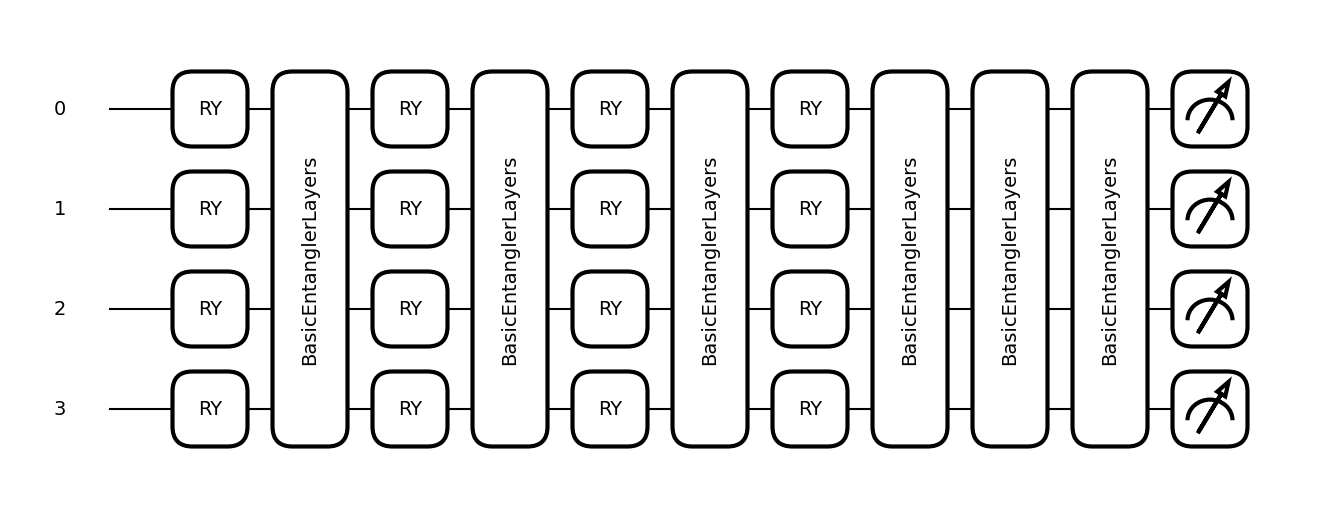

In [9]:
n_qubits = 4
n_layers = 3

full_dev = qml.device('default.qubit', wires = 4)
inp_params = torch.rand(2*4*n_qubits)
weight_params = torch.rand(3*n_qubits)
nn_params = torch.rand(n_layers*n_qubits)

full_qnode = qml.QNode(full_circuit, feature_dev)

qml.draw_mpl(full_circuit, range(4))(full_qnode, torch.tensor([0, 1, 2, 3]), inp_params, weight_params, nn_params, n_layers)

# PDE residual

In [10]:
def get_predicts(qnodes, X_batch, FM_input_weights, 
                FM_train_weights, NN_train_weights, TL_train_weights,
                n_layers, FMrot_seq, NNrot_seq):
    predictions = []
    for ii in range(4):
        res = TL_train_weights[ii][0]*qnodes[ii](qnodes[ii], X_batch, FM_input_weights[ii], 
                                              FM_train_weights[ii], NN_train_weights[ii], 
                                              n_layers, FMrot_seq, NNrot_seq) + TL_train_weights[ii][1]
        predictions.append(res)
    return predictions

In [11]:
phi0 = 11
phi0_rad = np.pi*phi0/180

Omega = 7.2921e-5
f0 = torch.tensor(2*Omega*np.sin(phi0_rad), dtype = torch.float32).to(torch_dev)
beta = torch.tensor(2*Omega*np.cos(phi0_rad)/radius_earth, dtype = torch.float32).to(torch_dev)

def pde_loss(qnodes, X_batch, FM_input_weights, FM_train_weights, NN_train_weights, TL_train_weights, n_layers, FMrot_seq, NNrot_seq):
        '''
        returns the burgers equation left-hand side residual by using the parameter-shift rule
        '''
        # Num qubitsF
        n_qubits = len(qnodes[0].device.wires)
        
        # U and V components of wind speed val
        u, v, w, _ = get_predicts(qnodes, X_batch, FM_input_weights, 
                FM_train_weights, NN_train_weights, TL_train_weights,
                n_layers, FMrot_seq, NNrot_seq)

        # partials of t
        par_t_u = 0
        par_t_v = 0
        for ii in range(n_qubits):
                # Zeros vec
                zeros_vec = torch.zeros(FM_input_weights.shape, dtype = torch.float32, device = torch_dev)
                zeros_vec[:, 2*ii+1] = torch.pi/2       #element to modify

                # Plus and minus shifts
                plus_train_FM = FM_input_weights+zeros_vec
                minus_train_FM = FM_input_weights-zeros_vec

                # calculate
                pos_term_u, pos_term_v, _, _ = get_predicts(qnodes, X_batch, plus_train_FM, 
                                                        FM_train_weights, NN_train_weights, TL_train_weights,
                                                        n_layers, FMrot_seq, NNrot_seq)
                neg_term_u, neg_term_v, _, _ = get_predicts(qnodes, X_batch, minus_train_FM, 
                                                        FM_train_weights, NN_train_weights, TL_train_weights,
                                                        n_layers, FMrot_seq, NNrot_seq) 

                # Partial accumulations
                par_t_u += (FM_input_weights[0][2*ii]/2)*(pos_term_u - neg_term_u)
                par_t_v += (FM_input_weights[1][2*ii]/2)*(pos_term_v - neg_term_v)

        # partials of x 
        par_x_u = 0
        par_x_v = 0
        par_x_G = 0
        for ii in range(n_qubits):
                # Zeros vec
                zeros_vec = torch.zeros(FM_input_weights.shape, dtype = torch.float32, device = torch_dev)
                zeros_vec[:, 2*n_qubits + 2*ii+1] = torch.pi/2       #element to modify

                # Plus and minus shifts
                plus_train_FM = FM_input_weights+zeros_vec
                minus_train_FM = FM_input_weights-zeros_vec

                # calculate
                pos_term_u, pos_term_v, _, pos_term_G = get_predicts(qnodes, X_batch, plus_train_FM, 
                                                        FM_train_weights, NN_train_weights, TL_train_weights,
                                                        n_layers, FMrot_seq, NNrot_seq)
                neg_term_u, neg_term_v, _, neg_term_G = get_predicts(qnodes, X_batch, minus_train_FM, 
                                                        FM_train_weights, NN_train_weights, TL_train_weights,
                                                        n_layers, FMrot_seq, NNrot_seq) 

                par_x_u += (FM_input_weights[0][2*n_qubits + 2*ii]/2)*(pos_term_u - neg_term_u)
                par_x_v += (FM_input_weights[1][2*n_qubits + 2*ii]/2)*(pos_term_v - neg_term_v)
                par_x_G += (FM_input_weights[3][2*n_qubits + 2*ii]/2)*(pos_term_G - neg_term_G)

        # partials of y 
        par_y_u = 0
        par_y_v = 0
        par_y_G = 0
        for ii in range(n_qubits):
                # Zeros vec
                zeros_vec = torch.zeros(FM_input_weights.shape, dtype = torch.float32, device = torch_dev)
                zeros_vec[:, 4*n_qubits + 2*ii+1] = torch.pi/2       #element to modify

                # Plus and minus shifts
                plus_train_FM = FM_input_weights+zeros_vec
                minus_train_FM = FM_input_weights-zeros_vec

                # calculate
                pos_term_u, pos_term_v, _, pos_term_G = get_predicts(qnodes, X_batch, plus_train_FM, 
                                                        FM_train_weights, NN_train_weights, TL_train_weights,
                                                        n_layers, FMrot_seq, NNrot_seq)
                neg_term_u, neg_term_v, _, neg_term_G = get_predicts(qnodes, X_batch, minus_train_FM, 
                                                        FM_train_weights, NN_train_weights, TL_train_weights,
                                                        n_layers, FMrot_seq, NNrot_seq) 
                
                par_y_u += (FM_input_weights[0][4*n_qubits + 2*ii]/2)*(pos_term_u - neg_term_u)
                par_y_v += (FM_input_weights[1][4*n_qubits + 2*ii]/2)*(pos_term_v - neg_term_v)
                par_y_G += (FM_input_weights[3][4*n_qubits + 2*ii]/2)*(pos_term_G - neg_term_G)

        # Partial of p
        par_p_u = 0
        par_p_v = 0
        par_p_w = 0

        for ii in range(n_qubits):
                # Zeros vec
                zeros_vec = torch.zeros(FM_input_weights.shape, dtype = torch.float32, device = torch_dev)
                zeros_vec[:, 6*n_qubits + 2*ii+1] = torch.pi/2       #element to modify

                # Plus and minus shifts
                plus_train_FM = FM_input_weights+zeros_vec
                minus_train_FM = FM_input_weights-zeros_vec

                # calculate
                pos_term_u, pos_term_v, pos_term_w, _ = get_predicts(qnodes, X_batch, plus_train_FM, 
                                                        FM_train_weights, NN_train_weights, TL_train_weights,
                                                        n_layers, FMrot_seq, NNrot_seq)
                neg_term_u, neg_term_v, neg_term_w, _= get_predicts(qnodes, X_batch, minus_train_FM, 
                                                        FM_train_weights, NN_train_weights, TL_train_weights,
                                                        n_layers, FMrot_seq, NNrot_seq) 
                
                par_p_u += (FM_input_weights[0][6*n_qubits + 2*ii]/2)*(pos_term_u - neg_term_u)
                par_p_v += (FM_input_weights[1][6*n_qubits + 2*ii]/2)*(pos_term_v - neg_term_v)
                par_p_w += (FM_input_weights[2][6*n_qubits + 2*ii]/2)*(pos_term_w - neg_term_w)

        mse1 = torch.abs((par_t_u*alpha_t + 
                                    ((u - beta_u)/alpha_u)*par_x_u + 
                                    ((v - beta_v)/alpha_v)*par_y_u + 
                                    w*par_p_u)/alpha_u - 
                                    (f0 + beta*((X_batch[2]-beta_y)/alpha_y))*((v-beta_v)/alpha_v) + 
                                    par_x_G*alpha_x/alpha_G)**2
        mse2 = torch.abs((par_t_v*alpha_t + 
                                    ((u - beta_u)/alpha_u)*par_x_v + 
                                    ((v - beta_v)/alpha_v)*par_y_v + 
                                    w*par_p_v)/alpha_v +
                                    (f0 + beta*((X_batch[2]-beta_y)/alpha_y))*((u-beta_u)/alpha_u)+ 
                                    par_y_G*alpha_y/alpha_G)**2
        mse3 = torch.abs(par_x_u*alpha_x/alpha_u + par_y_v*alpha_y/alpha_v + par_p_w)**2
        
        
        return torch.mean(mse1 + mse2 + mse3)

In [12]:
from tqdm.auto import tqdm
import time

def cost_fn(qnodes, X_batch, y_batch, n_layers, weights, gamma, FMrot_seq, NNrot_seq):
    n_qubits = len(qnodes[0].device.wires)

    # Indx lengths
    idx0 = 8*n_qubits
    idx1 = 3*n_qubits
    idx2 = n_layers*n_qubits
    idx3 = 2
    
    # Weights split u
    FM_input_weights = weights[:4*idx0].reshape(4, idx0)
    FM_train_weights = weights[4*idx0:4*(idx0 + idx1)].reshape(4, idx1)
    NN_train_weights = weights[4*(idx0 + idx1):4*(idx0 + idx1 + idx2)].reshape(4, idx2)
    TL_train_weights = weights[4*(idx0 + idx1 + idx2):4*(idx0 + idx1 + idx2 + idx3)].reshape(4, idx3)

    X_batch = torch.t(X_batch)
    y_batch = torch.t(y_batch)
    #X_batch = list(map(list, zip(*X_batch)))
    #y_batch = list(map(list, zip(*y_batch)))
    
    if gamma != 1:
        predict_u, predict_v, _, predict_G = get_predicts(qnodes, X_batch, FM_input_weights, 
                    FM_train_weights, NN_train_weights, TL_train_weights,
                    n_layers, FMrot_seq, NNrot_seq)
        loss_u = (predict_u - y_batch[0])**2
        loss_v = (predict_v - y_batch[1])**2
        loss_G = (predict_G - y_batch[2])**2
        static_loss = torch.mean(torch.sqrt(y_batch[0]**2 + y_batch[1]**2)*(loss_u + loss_v + loss_G))
    else:
        static_loss = 0

    if gamma != 0:
        physics_loss = pde_loss(qnodes, X_batch, FM_input_weights, FM_train_weights, NN_train_weights, TL_train_weights, n_layers,  FMrot_seq, NNrot_seq)
    else:
        physics_loss = 0
    cost =  (1-gamma)*static_loss +  gamma*physics_loss

    return cost

In [13]:
BATCH_SIZE = 61*30*5
train_dataloader = DataLoader(train_dataset, BATCH_SIZE, shuffle = False)
test_dataloader = DataLoader(test_dataset, BATCH_SIZE, shuffle = False)

# Draw Figures

In [14]:
new_params = torch.load('best_params_mix2.pth',map_location=torch.device('cpu')).to(torch_dev)
new_params.shape

/tmp/ipykernel_92703/782494101.py:1: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  new_params = torch.load('best_params_mix2.pth',map_location=torch.device('cpu')).to(torch_

torch.Size([248])

/tmp/ipykernel_92703/1416149675.py:4: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  train_cost_reg = torch.load('train_cost_mix2.pth',map_location=torch.device('cpu'))
/tmp/

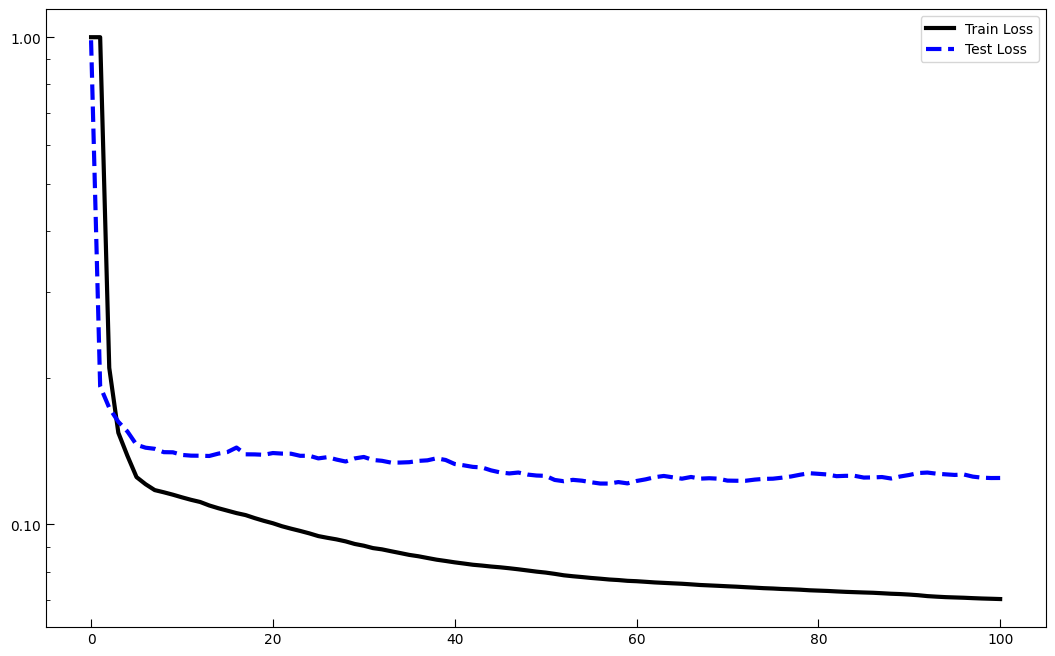

In [36]:
import torch
import matplotlib.pyplot as plt

train_cost_reg = torch.load('train_cost_mix2.pth',map_location=torch.device('cpu'))
test_cost_reg = torch.load('test_cost_mix2.pth',map_location=torch.device('cpu'))

golden_ratio = 1.618033
x_size = 10
y_size = 10/golden_ratio
plt.figure(figsize=(x_size, y_size))

plt.plot(train_cost_reg, 'k', label = 'Train Loss', linewidth = 3)
plt.plot(test_cost_reg, 'b--', label = 'Test Loss', linewidth = 3)

plt.yscale('log')

plt.tick_params(axis='x', direction='in', length=6, which='major')
plt.tick_params(axis='x', direction='in', length=3, which='minor')
plt.tick_params(axis='y', direction='in', length=6, which='major')
plt.tick_params(axis='y', direction='in', length=3, which='minor')

# Ensure ticks align correctly with the log scale
# This can help adjust the tick placement if needed
plt.gca().xaxis.set_major_formatter(plt.ScalarFormatter())
plt.gca().yaxis.set_major_formatter(plt.ScalarFormatter())


# COMENTA ESTO PARA VER LOS RANGOS (DESCOMENTA PARA HACER LA IMAGEN BONITA EN INKSCAPE)
#plt.xticks(ticks=plt.xticks()[0], labels=['']*len(plt.xticks()[0]))
#plt.yticks(ticks=plt.yticks()[0], labels=['']*len(plt.yticks()[0]))

# COMENTA ESTO PARA VER EL AUTOAJUSTE (DESCOMENTA Y AGREGA LIMITES PA QUE SE VEA BONITO)
#plt.ylim(0.02, 2)
#plt.xlim(-2, 52)

plt.legend()

plt.subplots_adjust(left=0, right=1, top=1, bottom=0)

plt.savefig('Loss_0_05_physics.svg')

In [16]:
# Create qnode
device = qml.device('default.qubit.torch', 
                    wires = n_qubits,
                    torch_device = torch_dev)
qnode_u = qml.QNode(full_circuit, device = device, interface = 'torch', diff_method = 'best')
qnode_v = qml.QNode(full_circuit, device = device, interface = 'torch', diff_method = 'best')
qnode_w = qml.QNode(full_circuit, device = device, interface = 'torch', diff_method = 'best')
qnode_G = qml.QNode(full_circuit, device = device, interface = 'torch', diff_method = 'best')

qnodes = [qnode_u, qnode_v, qnode_w, qnode_G]

In [17]:
# Create quantum circuit qnode and parameters
n_layers = 4
n_qubits = 4

ii = 0
for X_batch, y_batch in test_dataloader:
    if ii == 0:
        break
    ii += 1

X_batch = torch.t(X_batch)
y_batch = torch.t(y_batch)

# Indx lengths
idx0 = 8*n_qubits
idx1 = 3*n_qubits
idx2 = n_layers*n_qubits
idx3 = 2

# Weights split u
FM_input_weights = new_params[:4*idx0].reshape(4, idx0)
FM_train_weights = new_params[4*idx0:4*(idx0 + idx1)].reshape(4, idx1)
NN_train_weights = new_params[4*(idx0 + idx1):4*(idx0 + idx1 + idx2)].reshape(4, idx2)
TL_train_weights = new_params[4*(idx0 + idx1 + idx2):4*(idx0 + idx1 + idx2 + idx3)].reshape(4, idx3)

with torch.no_grad():
    predict_u, predict_v, _, predict_G =  get_predicts(qnodes, X_batch[:, 2*1830:3*1830], FM_input_weights, 
                    FM_train_weights, NN_train_weights, TL_train_weights,
                    n_layers, [qml.RX], [qml.RX])

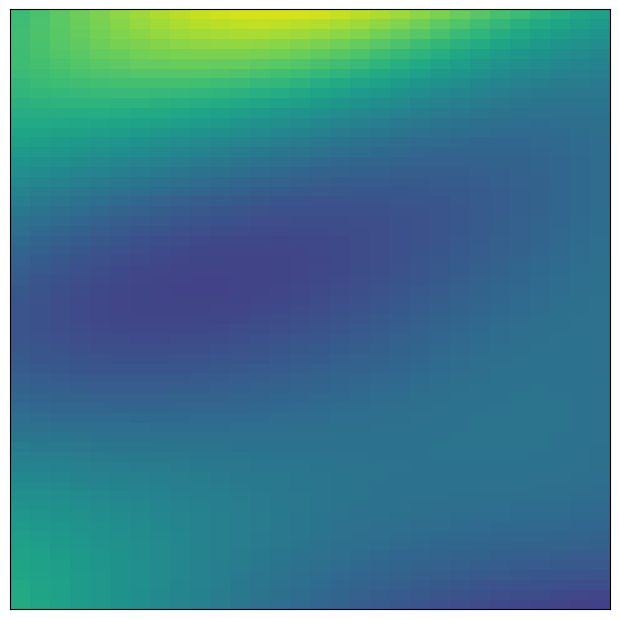

In [18]:
wind_u_test = torch.t(predict_u.reshape(y_len, x_len))

fig, ax = plt.subplots(figsize = (6, 6))
ax.pcolor(wind_u_test.cpu().detach().numpy(), vmin = -1, vmax = 1)
ax.set_xticks([])
ax.set_yticks([])

plt.subplots_adjust(left=0, right=1, top=1, bottom=0)

plt.savefig('Gamma_0_05_Physics_wind_u_predict.png')

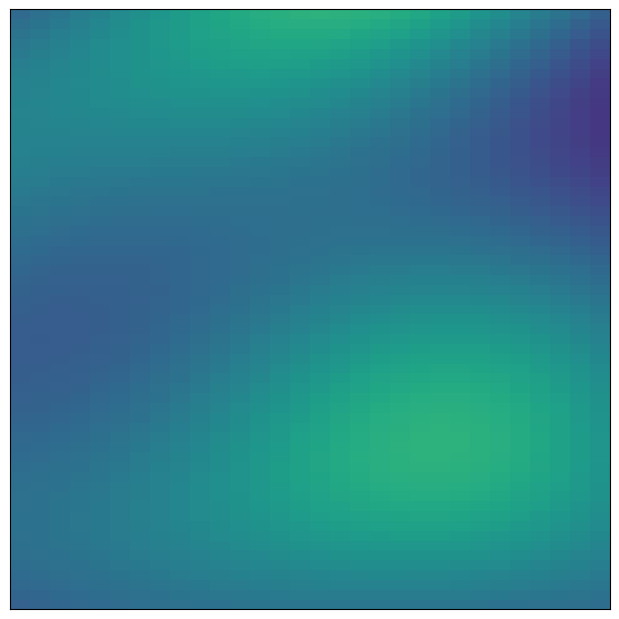

In [19]:
wind_u_test = torch.t(predict_v.reshape(y_len, x_len))

fig, ax = plt.subplots(figsize = (6, 6))
ax.pcolor(wind_u_test.cpu().detach().numpy(), vmin = -1, vmax = 1)
ax.set_xticks([])
ax.set_yticks([])

plt.subplots_adjust(left=0, right=1, top=1, bottom=0)

plt.savefig('Gamma_0_05_Physics_wind_v_predict.png')

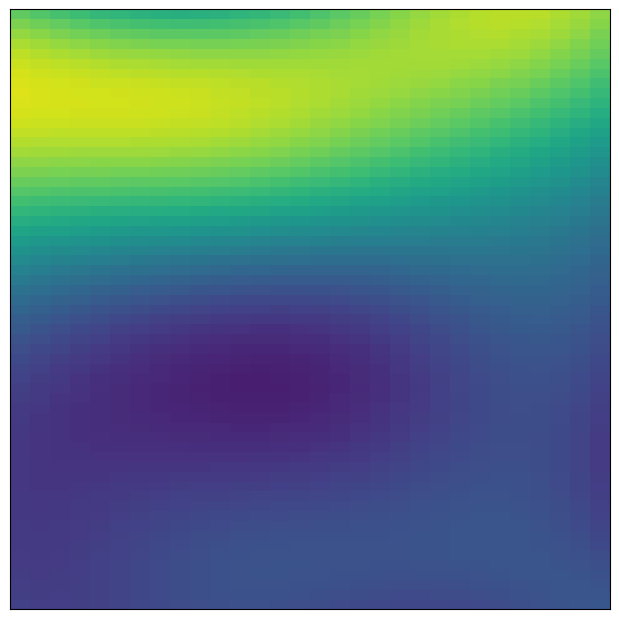

In [20]:
wind_u_test = torch.t(predict_G.reshape(y_len, x_len))

fig, ax = plt.subplots(figsize = (6, 6))
ax.pcolor(wind_u_test.cpu().detach().numpy(), vmin = -1, vmax = 1)
ax.set_xticks([])
ax.set_yticks([])

plt.subplots_adjust(left=0, right=1, top=1, bottom=0)

plt.savefig('Gamma_0_05_Physics_wind_G_predict.png')

## Absolute errors figures

In [21]:
abs_u_test = torch.abs(torch.t(predict_u.reshape(y_len, x_len)) - torch.t(y_batch[0, 2*1830:3*1830].reshape(y_len, x_len)))
abs_v_test = torch.abs(torch.t(predict_v.reshape(y_len, x_len)) - torch.t(y_batch[1, 2*1830:3*1830].reshape(y_len, x_len)))
abs_G_test = torch.abs(torch.t(predict_G.reshape(y_len, x_len)) - torch.t(y_batch[2, 2*1830:3*1830].reshape(y_len, x_len)))

In [22]:
max_error = max([abs_u_test.max(), abs_v_test.max(), abs_G_test.max()])
max_error = torch.ceil(max_error*2).item()/2
max_error

2.0

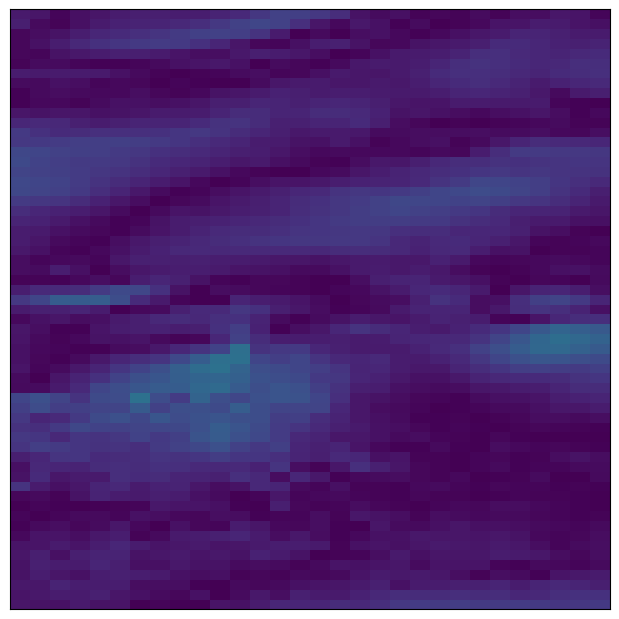

In [33]:
fig, ax = plt.subplots(figsize = (6, 6))
ax.pcolor(abs_u_test.cpu().detach().numpy(), vmin = 0, vmax = max_error)
ax.set_xticks([])
ax.set_yticks([])

plt.subplots_adjust(left=0, right=1, top=1, bottom=0)

#plt.savefig('Gamma_0_05_Physics_wind_u_predict_ERROR.png')

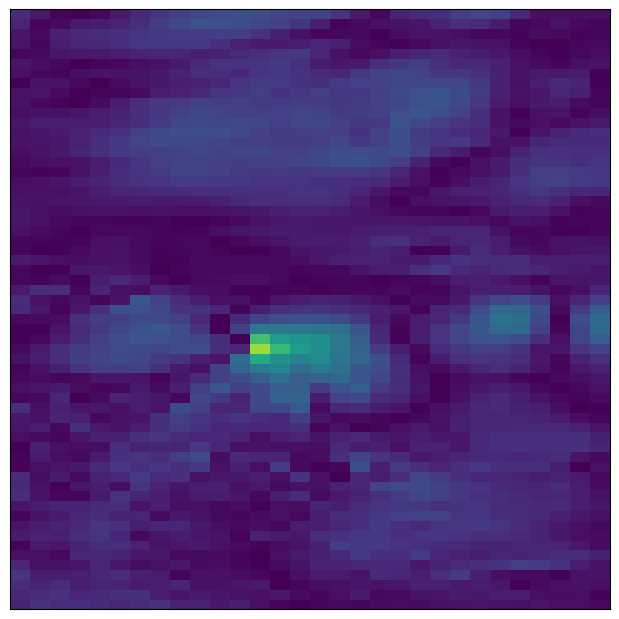

In [24]:
fig, ax = plt.subplots(figsize = (6, 6))
ax.pcolor(abs_v_test.cpu().detach().numpy(), vmin = 0, vmax = max_error)
ax.set_xticks([])
ax.set_yticks([])
 
plt.subplots_adjust(left=0, right=1, top=1, bottom=0)
plt.savefig('Gamma_0_05_Physics_wind_V_predict_ERROR.png')

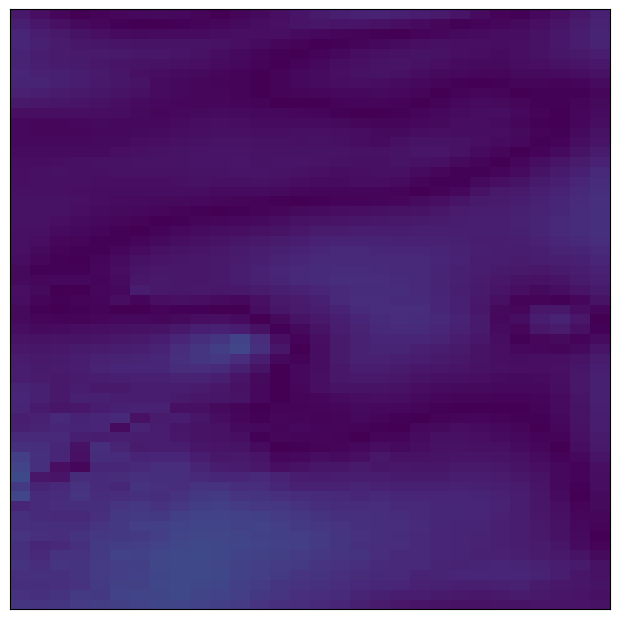

In [25]:
fig, ax = plt.subplots(figsize = (6, 6))
ax.pcolor(abs_G_test.cpu().detach().numpy(), vmin = 0, vmax = max_error)
ax.set_xticks([])
ax.set_yticks([])

plt.subplots_adjust(left=0, right=1, top=1, bottom=0)

plt.savefig('Gamma_0_05_Physics_wind_G_predict_ERROR.png')